### Code structure
1. A lot of EDA was initially done in R codes which are pasted in the below cell just for reference
2. Further some explorations were done in Python notebook. The whole data pre-processing and modeling was also done in Python. All these are available after the R code cell below.

### EDA notes
1. Data was visualized with various dimensions to understand how the trip duration was related to other available features
2. Some additional features were created to get more interesting aspects of the overall data; e.g. the spherical distance between two location co-ordinates, time of day, day of week, month of year, a proxy info about traffic via the average number of trips in a small region|time window|day type etc.
    a) A simple imputation method was defined for traffic info as the location-time-day combination in test data may not be available in train data. 
    b) We extracted average traffic at pickup location, also the average traffic at dropoff location for the pickup time itself (as we won't know the dropoff time in advance).
3. Some transformations were applied on features, e.g. interaction of pickup day type and pickup hour of day, log of trip duration, log of distance

### Model notes
1. Multiple regresson model forms were tested;  
    a) `GammaRegressor` used considering close to Gamma distributional form of trip duration identified during EDA. However it produced RMSLE around 0.44 which was quite higher than other tree based models.  
    b) `HistGradientBoostingRegressor` and `RandomForestRegressor` were tested. Some hyper-parameter tuning was done using cross-validation and grid search features of SKLearn.  
    c) Used one-hot encoding for `RandomForestRegressor` model of categorical features; but considered them as ordinal in `HistGradientBoostingRegressor` as it natively supports categorical features (uses binning to discretize the whole data).  
    d) Data was standardized (mean 0 and variance 1) before training, even if it does not impact tree based or linear regression models.
2. Small ranges of various hyper-parameters were tested in sequence using grid-search (e.g., considered ranges of p1, p2, p3 in first step; then p4, p5 in sencond step using best param values of p1-p3 identified in the first step, etc.)
3. Finally, a variable importance info was extracted using the final tuned model using SKLearn to get a sense how each of the features contributed to the model in predicting trip duration


-----------
#### Python codes for EDA

In [1]:
# Importing libraries for further EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import holidays

In [2]:
tr = pd.read_csv("train.zip", parse_dates=["pickup_datetime","dropoff_datetime"], infer_datetime_format=True)
tr.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
def HaversineDistance(lat1,lon1,lat2,lon2):
	"""
	Returns the distance between two lat-long cordinates in km
	"""
	REarth = 6371
	lat = np.abs(np.array(lat1)-np.array(lat2))*np.pi/180
	lon = np.abs(np.array(lon1)-np.array(lon2))*np.pi/180
	lat1 = np.array(lat1)*np.pi/180
	lat2 = np.array(lat2)*np.pi/180
	a = np.sin(lat/2)*np.sin(lat/2)+np.cos(lat1)*np.cos(lat2)*np.sin(lon/2)*np.sin(lon/2)
	d = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
	d = REarth*d
	return d

In [4]:
# Add some variables based on the existing data to visualize it in various dimensions
tr["distance"] = (
    HaversineDistance(
        tr.loc[:, "pickup_latitude"], tr.loc[:, "pickup_longitude"], 
        tr.loc[:, "dropoff_latitude"], tr.loc[:, "dropoff_longitude"]
    )
)
tr["log_distance"] = np.log(tr.loc[:, 'distance'])
tr["log_duration"] = np.log(tr.loc[:, 'trip_duration'])
tr['pickup_day_of_week'] = tr.loc[:, "pickup_datetime"].dt.day_name().astype('category')
tr['pickup_month_of_year'] = tr.loc[:, "pickup_datetime"].dt.month_name().astype('category')
tr['pickup_hour_of_day'] = tr.loc[:, "pickup_datetime"].dt.hour.astype('category')

# Consider adding orders for categorical data to get the plots in nice way
tr['pickup_day_of_week'] = tr['pickup_day_of_week'].cat.set_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
tr['pickup_month_of_year'] = tr['pickup_month_of_year'].cat.set_categories(['January','February','March','April','May','June','July','August','September','October','November','December'], ordered=True)
tr['pickup_hour_of_day'] = tr['pickup_hour_of_day'].cat.set_categories(np.arange(0,24), ordered=True)

tr.head()

c:\Users\atal\Documents\PyEnv\MITA\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,log_distance,log_duration,pickup_day_of_week,pickup_month_of_year,pickup_hour_of_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,0.404478,6.120297,Monday,March,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,0.590842,6.496775,Sunday,June,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,1.853967,7.661056,Tuesday,January,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,0.395750,6.061457,Wednesday,April,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,0.172766,6.075346,Saturday,March,13


In [5]:
tr.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,log_distance,log_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.440864e+00,-inf,6.464521e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,4.296538e+00,NaN,7.996122e-01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,-inf,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.231837e+00,2.085062e-01,5.983936e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,2.093717e+00,7.389410e-01,6.495266e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,3.875337e+00,1.354633e+00,6.980076e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,1.240909e+03,7.123599e+00,1.507575e+01


In [6]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1458644 non-null  object        
 1   vendor_id             1458644 non-null  int64         
 2   pickup_datetime       1458644 non-null  datetime64[ns]
 3   dropoff_datetime      1458644 non-null  datetime64[ns]
 4   passenger_count       1458644 non-null  int64         
 5   pickup_longitude      1458644 non-null  float64       
 6   pickup_latitude       1458644 non-null  float64       
 7   dropoff_longitude     1458644 non-null  float64       
 8   dropoff_latitude      1458644 non-null  float64       
 9   store_and_fwd_flag    1458644 non-null  object        
 10  trip_duration         1458644 non-null  int64         
 11  distance              1458644 non-null  float64       
 12  log_distance          1458644 non-null  fl

In [7]:
tr.isnull().sum(axis=0)

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
store_and_fwd_flag      0
trip_duration           0
distance                0
log_distance            0
log_duration            0
pickup_day_of_week      0
pickup_month_of_year    0
pickup_hour_of_day      0
dtype: int64

<AxesSubplot:title={'center':'Histogram of log(trip duration) where duration <1M secs'}, ylabel='Frequency'>

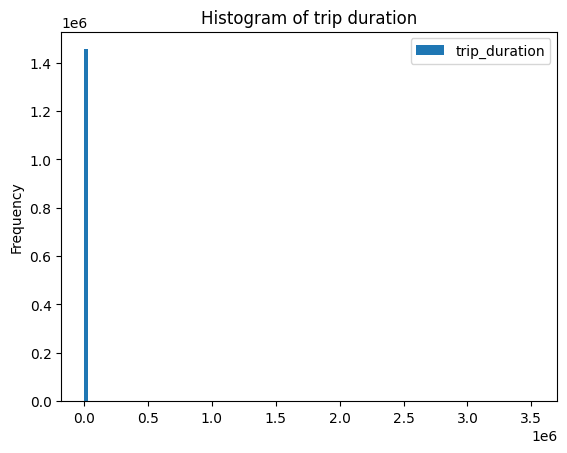

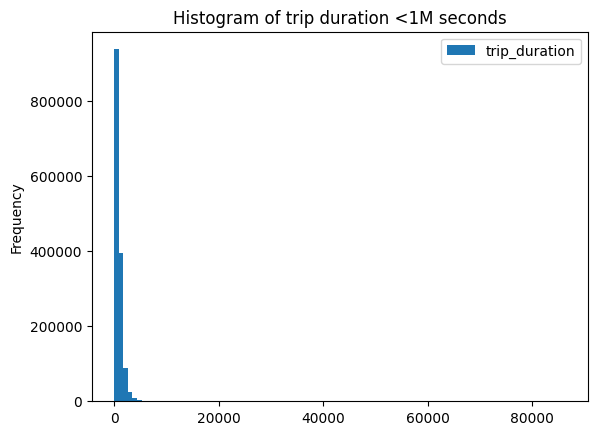

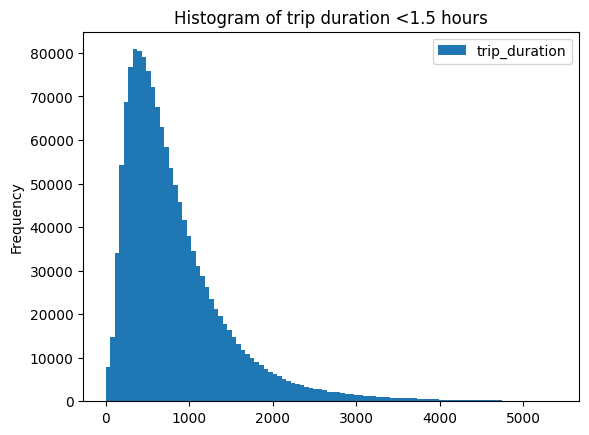

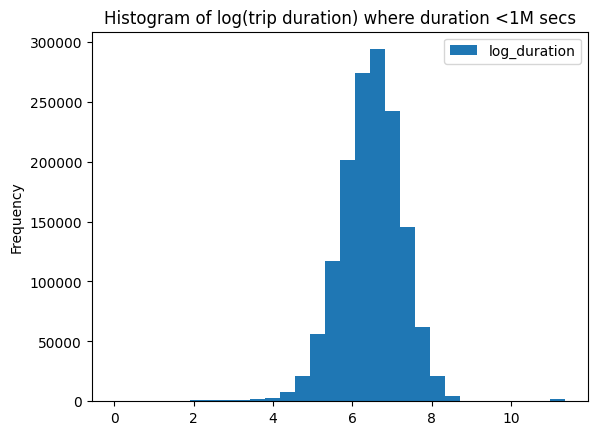

In [8]:
# Histogram of trip duration
(
    tr
    .plot
    .hist(
        y='trip_duration', bins=100, 
        xlabel="trip_duration", title="Histogram of trip duration"
    )
)

# Histogram of trip duration <1M seconds
(
    tr[tr.trip_duration<=10**6]
    .plot
    .hist(
        y='trip_duration', bins=100, 
        xlabel="trip_duration", title="Histogram of trip duration <1M seconds"
    )
)

# Histogram of trip duration <1.5 hours
(
    tr[tr.trip_duration<=5400]
    .plot
    .hist(
        y='trip_duration', bins=100, 
        xlabel="trip_duration", title="Histogram of trip duration <1.5 hours"
    )
)
# Histogram of log(trip duration) where trip_duration <1.5 hours
(
    tr[tr.trip_duration<=10**6]
    .plot
    .hist(
        y='log_duration',  bins=30,
        xlabel="log(trip_duration)", title="Histogram of log(trip duration) where duration <1M secs"
    )
)


1. Trip duration is abnormally high, >1M seconds.  
2. Also, there are only 3K trips (0.2% records) whose duration >1.5 hrs (5400 seconds).  
3. Mode of the trip duration distribution is around 400 seconds, <7 minutes.  
4. It has a huge right tail (positively skewed).  
5. It is not Normally distributed, closer to Gamma distribution.  
6. Log transformation makes it more symmetric and closer to Normal distribution

<AxesSubplot:title={'center':'Scatterplot of log(duration) vs log(distance)'}, xlabel='log_distance', ylabel='log_duration'>

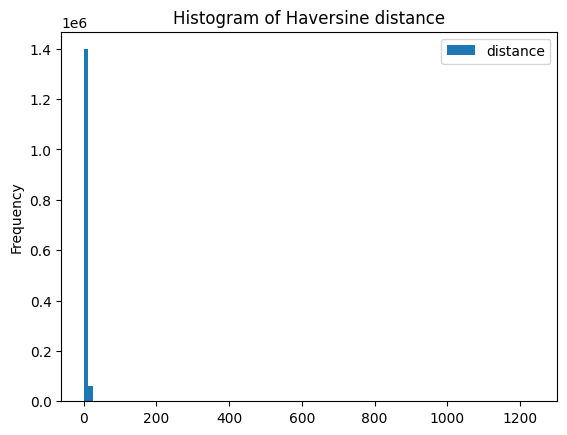

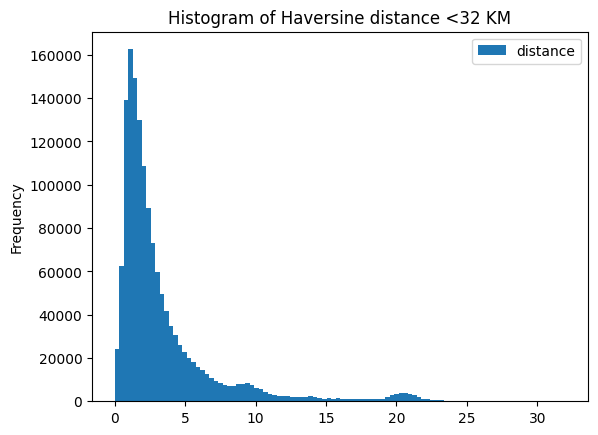

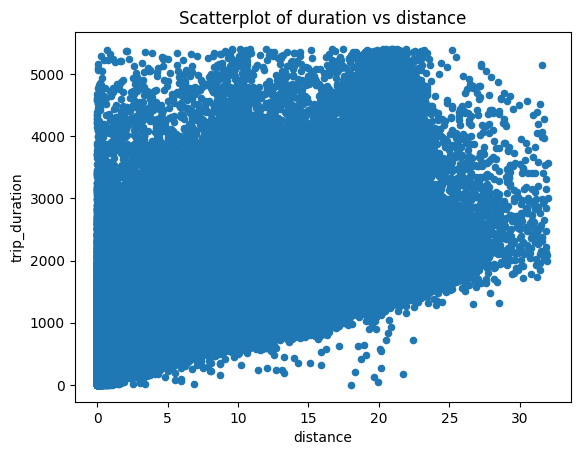

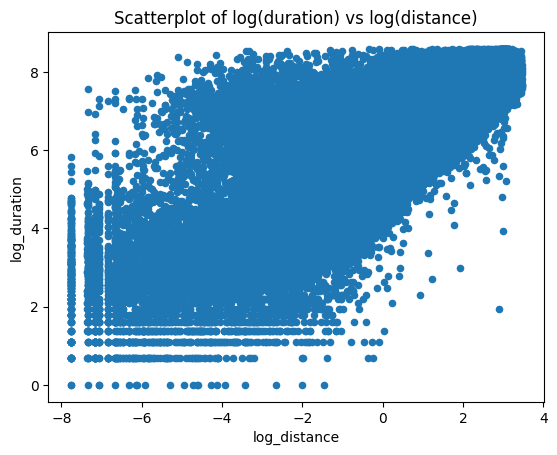

In [9]:
# Histogram of distance
(
    tr
    .plot
    .hist(
        y='distance', bins=100, 
        xlabel="distance", title="Histogram of Haversine distance"
    )
)

# Histogram of distance <32KM
(
    tr[tr.distance<=32]
    .plot
    .hist(
        y='distance', bins=100, 
        xlabel="distance", title="Histogram of Haversine distance <32 KM"
    )
)
# Scatter plot of distance with duration (duration <1.5 hours, distance<32KM)
(
    tr[(tr.trip_duration<=5400)&(tr.distance<=32)]
    .plot
    .scatter(
        y='trip_duration', x='distance',
        title="Scatterplot of duration vs distance"
    )
)
# Scatter plot of log_distance with log_duration (duration <1.5 hours, distance<32KM)
(
    tr[(tr.trip_duration<=5400)&(tr.distance<=32)]
    .plot
    .scatter(
        y='log_duration', x='log_distance',
        title="Scatterplot of log(duration) vs log(distance)"
    )
)


1. Most of the trips are for <25 KM distance as per Haversine formula.  
2. Some outliers are noted where the distance is in thousands of KM.  
3. Scatter plot exhibits somewhat linear relation between distance and duration, there are many datapoints where duration is
quite high even though distance is not large.  
4. Scatter plot of log(distance) vs log(duration) looks more linear in nature compared to the previous scatter plot without any transformation.

In [10]:
# Quick function to plot average duration grouped by a given feature
def plot_byvar(byvar):
    (
        tr[(tr.trip_duration<=5400)&(tr.distance<=32)]
        .groupby([byvar]).mean()
        .plot
        .barh(
            y='trip_duration', 
            xlabel=byvar, title="Average trip duration by " + byvar
        )
    )

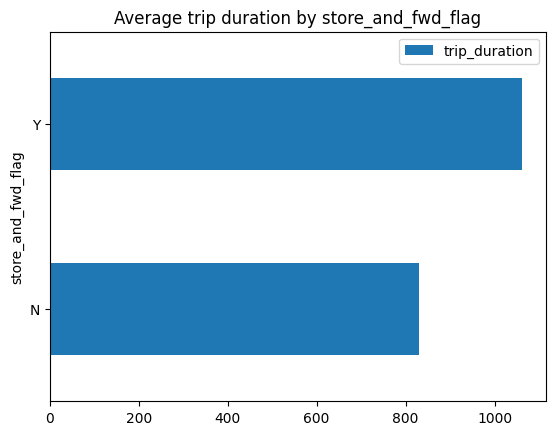

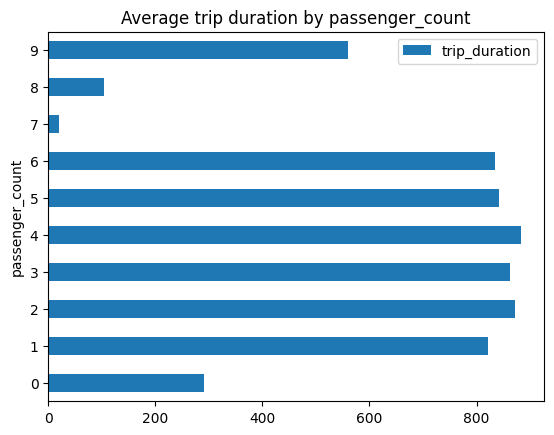

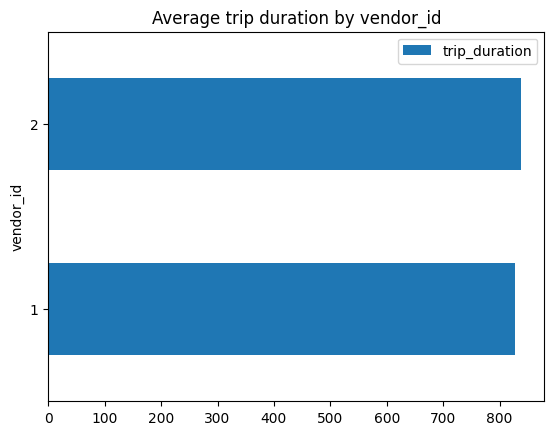

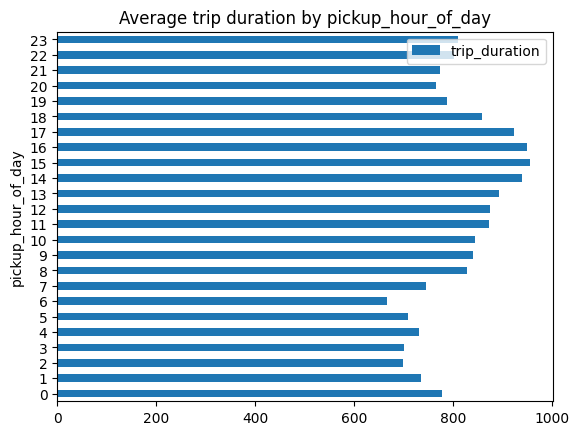

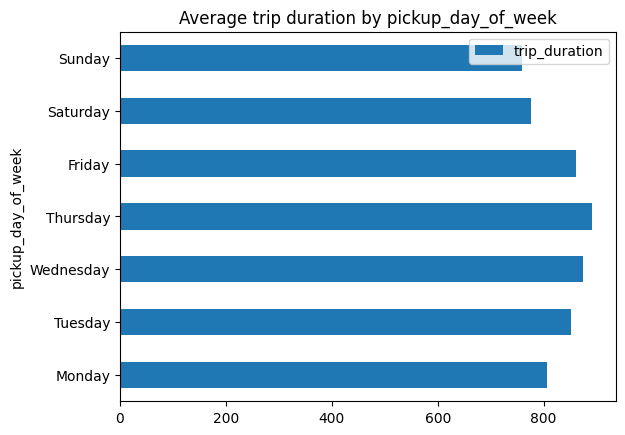

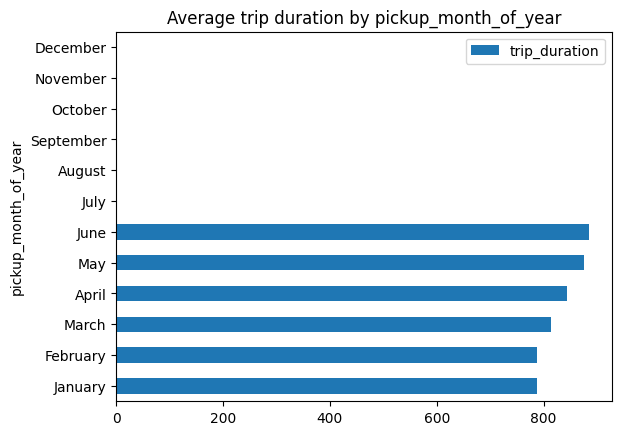

In [11]:
plot_byvar('store_and_fwd_flag')
plot_byvar('passenger_count')
plot_byvar('vendor_id')
plot_byvar('pickup_hour_of_day')
plot_byvar('pickup_day_of_week')
plot_byvar('pickup_month_of_year')


1. Average trip duration for `store_and_fwd_flag` =Y is quite highers than =N.  
2. Trip duration usually higher for `passenger_count` 2 to 4. Some 60 trips are there with 0 passengers!  
3. Vendor 2 taxis take ~2-3% more time than vendor 1.  
4. Trip duration is highest during evening.  
5. Trip durations are usually high during Tue to Fri.  
6. Trip duration gradually increases as summer period approaches.  

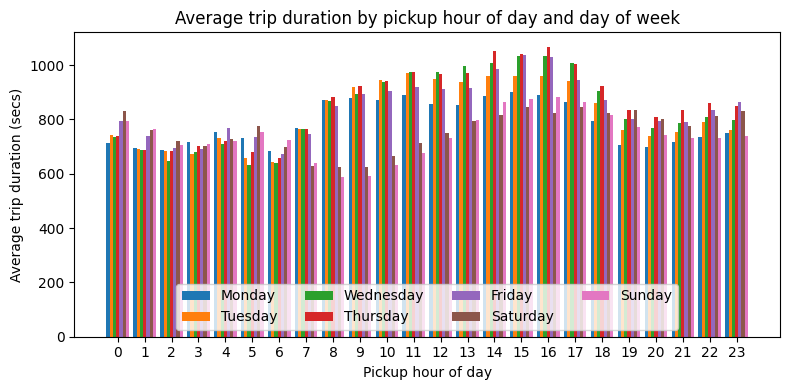

In [12]:
# Plot average trip duration by combination of day & hour
tr_1 = (
    tr[(tr.trip_duration<=5400)&(tr.distance<=32)]
    .groupby(['pickup_hour_of_day', 'pickup_day_of_week'], as_index=False)['trip_duration'].mean()
)

x = np.arange(len(tr_1.pickup_hour_of_day.unique()))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width*3, tr_1.loc[(tr_1.pickup_day_of_week=='Monday'), 'trip_duration'], width, label='Monday')
ax.bar(x - width*2, tr_1.loc[(tr_1.pickup_day_of_week=='Tuesday'), 'trip_duration'], width, label='Tuesday')
ax.bar(x - width*1, tr_1.loc[(tr_1.pickup_day_of_week=='Wednesday'), 'trip_duration'], width, label='Wednesday')
ax.bar(x , tr_1.loc[(tr_1.pickup_day_of_week=='Thursday'), 'trip_duration'], width, label='Thursday')
ax.bar(x + width*1, tr_1.loc[(tr_1.pickup_day_of_week=='Friday'), 'trip_duration'], width, label='Friday')
ax.bar(x + width*2, tr_1.loc[(tr_1.pickup_day_of_week=='Saturday'), 'trip_duration'], width, label='Saturday')
ax.bar(x + width*3, tr_1.loc[(tr_1.pickup_day_of_week=='Sunday'), 'trip_duration'], width, label='Sunday')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Pickup hour of day')
ax.set_ylabel('Average trip duration (secs)')
ax.set_title('Average trip duration by pickup hour of day and day of week')
ax.set_xticks(x, tr_1.pickup_hour_of_day.unique())
ax.legend(loc='lower center', ncol=4)

fig.tight_layout()


1. Average trip duration is higher on weekends after midnight until early morning.  
2. Average trip duration gradually increases throughout the day on weekdays.  

In [13]:
# Many trips with same pickup & dropoff locations; also some with distance <10 meters
print(tr[(tr.trip_duration<=5400) & (tr.distance==0)].shape)
print(tr[(tr.trip_duration<=5400) & (tr.distance<=0.01)].shape)

(5893, 17)
(8652, 17)


1. ~6K trips are with same pickup & dropoff locations, hence distance became 0!  
2. ~3K trips have Haversine distance <10 meters - could be bad data?

<AxesSubplot:title={'center':'Scatterplot of distance vs duration having distance 0.01 KM'}, xlabel='trip_duration', ylabel='distance'>

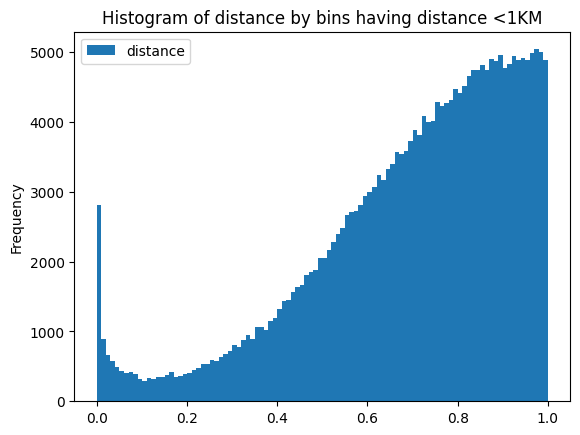

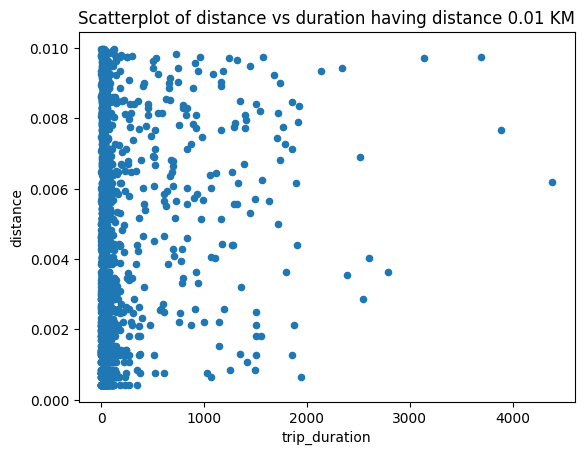

In [14]:
# Focusing on trips having distance <1km
tr[(tr.trip_duration<=5400) & (tr.distance<=1) & (tr.distance>0)].plot.hist(y='distance', bins=100, title="Histogram of distance by bins having distance <1KM")
tr[(tr.trip_duration<=5400) & (tr.distance<=0.01) & (tr.distance>0)].plot.scatter(x='trip_duration', y='distance', title="Scatterplot of distance vs duration having distance 0.01 KM")

1. Lots of trips are there where distance is very very small.  
2. Still in some of those cases the duration is all over the place, upto ~1 hour.  

<AxesSubplot:title={'center':'Dropoff lat vs long distribution'}, xlabel='dropoff_latitude', ylabel='dropoff_longitude'>

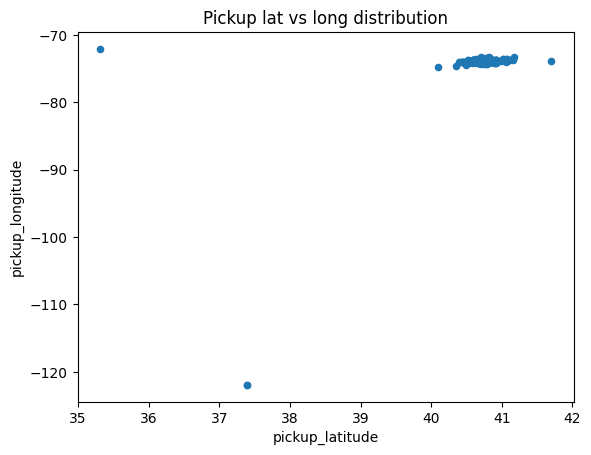

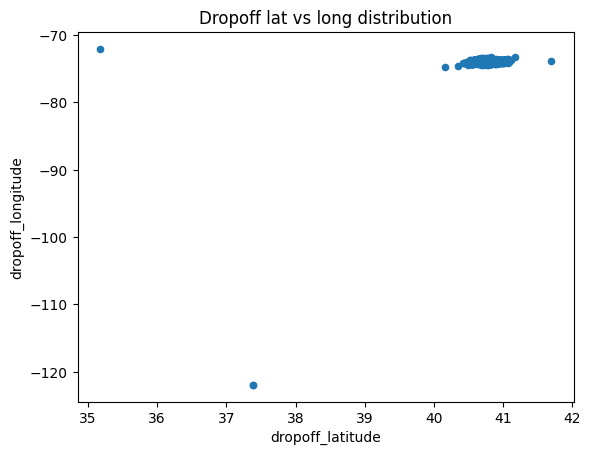

In [15]:
# Some lat-longs are very far away from the other data points, most likely bad data
tr[(tr.trip_duration<=5400) & (tr.distance<=32) & (tr.distance>0.01)].plot.scatter(x='pickup_latitude', y='pickup_longitude', title="Pickup lat vs long distribution")
tr[(tr.trip_duration<=5400) & (tr.distance<=32) & (tr.distance>0.01)].plot.scatter(x='dropoff_latitude', y='dropoff_longitude', title="Dropoff lat vs long distribution")

1. We may discard the data points where pickup/dropoff latitude < 39.  

------------
#### Post the above EDA, final data pre-processing  
After all the explorations done, planning to remove below cases:
1. `distance` >32 or `distance` <0.01
2. `trip_duration` >5400
3. `pickup_latitude` <39
4. `passenger_count` ==0

Below feature engineering to be done:
1. Calculate Haversine distance using pickup and dropoff coordinates
2. Categorize `passenger_count` into buckets: 1, 2 to 4, >4. And do one-hot encoding (or ordinal encoding?)
3. Pickup day of week. Categorize as [Tue, Wed, Thu], [Fri], [Sat], [Sun], [Mon]. One-hot encoding (or ordinal encoding?)
4. Pickup hour of day. Categorize as 00-04, 05-06, 07-10, 11-13, 14-18, 19-23. One-hot encoding.
5. Interaction of above two categorical variables.
6. Pickup month of year. Ordinal encoding for now, training data is for Jan to Jun.
7. Pickup date within +/- 1 day of holiday - 0,1.
8. Average number of trips within a small region (+/- 0.01 of lat or long), within a small time window (15mins window of a day), and calculate it by day type (weekday | weekend) or ([Tue, Wed, Thu], [Fri], [Sat], [Sun], [Mon]).  
    a) Calculate this traffic info by stacking [pickup datetime, pickup lat-long] and [dropoff datetime, dropoff lat-long] using the complete data. Group by location block, time window, day type, date (not datetime) and extract total number of trips; then group by location block, time window, day type and take average of #trips.   
    b) Then merge this traffic info with training data based on pickup datetime and pickup lat-long to define traffic_pickup. It will give a sense if the pickup area is congested or not. We may also merge it based on dropoff lat-long and pickup datetime to get a approximate sense of traffic_dropoff.  
    c) For now, not defining any sophisticated imputing strategy for test data (some combination of time window, day type, location may not be seen earlier while calculating traffic). If any of the attributes are not found in traffic dataset, then calculate average traffic of (traffic_given_location, traffic_given_timewindow, traffic_given_daytype) in test data, and use that as a proxy.

Check [HistGradientBoostingRegressor](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py) in sklearn!

In [16]:
# Distance calculation function between a pair of lat-longs
def HaversineDistance(lat1,lon1,lat2,lon2):
	"""
	Returns the distance between two lat-long cordinates in km
	"""
	REarth = 6371
	lat = np.abs(np.array(lat1)-np.array(lat2))*np.pi/180
	lon = np.abs(np.array(lon1)-np.array(lon2))*np.pi/180
	lat1 = np.array(lat1)*np.pi/180
	lat2 = np.array(lat2)*np.pi/180
	a = np.sin(lat/2)*np.sin(lat/2)+np.cos(lat1)*np.cos(lat2)*np.sin(lon/2)*np.sin(lon/2)
	d = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
	d = REarth*d
	return d

# Derive some sort of traffic indicator based on avg number of daily trips in a given small region, time window, day type
def derive_traffic(df, time_window=15, loc_bin=0.01):
    """
    Avg traffic calculation based on number of trips
    
    Average number of trips within a small region (+/- param `loc_bin` of lat or long), within a small 
	time window (param `time_window` minutes of a day), and calculate it by day type 
	(midweek: [Tue, Wed, Thu], [Fri], [Sat], [Sun], [Mon]).  

    Calculate this traffic info by stacking [pickup datetime, pickup lat-long] and 
	[dropoff datetime, dropoff lat-long] using the complete data. Group by location block, 
	time window, day type, date (not datetime) and extract total number of trips; then group by 
	location block, time window, day type and take average of #trips.   
	"""
    traffic = pd.concat(
        [
        (
        df
        .loc[:, ['id', 'pickup_latitude', 'pickup_longitude', 'pickup_datetime']]
        .rename(columns={"pickup_latitude": "latitude", "pickup_longitude": "longitude", "pickup_datetime": "datetime"})
        ),
        (
        df
        .loc[:, ['id', 'dropoff_latitude', 'dropoff_longitude', 'dropoff_datetime']]
        .rename(columns={"dropoff_latitude": "latitude", "dropoff_longitude": "longitude", "dropoff_datetime": "datetime"})
        )
        ], 
        ignore_index=True
    )
    # day of week bucket
    traffic['day'] = traffic.loc[:, "datetime"].dt.dayofweek  # 0 Monday, 6 Sunday
    traffic['day_b'] = "midweek"
    traffic.loc[(traffic['day'].isin([0,4,5,6])), 'day_b'] = traffic.loc[(traffic['day'].isin([0,4,5,6])), 'datetime'].dt.day_name()
    # time bucket
    traffic['time_bin']=pd.to_datetime(
        np.floor(pd.to_numeric(traffic.loc[:, 'datetime'])/(time_window*60*10**9))*time_window*60*10**9
    ).dt.time
    # lat-long bucket
    traffic['lat_bin']=np.floor(traffic.loc[:, 'latitude']/loc_bin)*loc_bin
    traffic['long_bin']=np.floor(traffic.loc[:, 'longitude']/loc_bin)*loc_bin
    # date
    traffic['date']=traffic.loc[:, 'datetime'].dt.date
    # average daily traffic by lat-long bin, time bin, day type
    return (
        traffic
        .groupby(['lat_bin', 'long_bin', 'time_bin', 'day_b', 'date'], as_index=False, sort=False)['id']
        .count()
        .groupby(['lat_bin', 'long_bin', 'time_bin', 'day_b'], as_index=False, sort=False)['id']
        .mean()
        .rename(columns={"id": "avg_traffic"})
    )

def traffic_nearby(lat, long, traffic_df):
    """
    Find average of traffic info for a given lat-long.
    If it is found then good, else keep on increasing the boundary by 0.03 for both lat & long.
    """
    i=0
    tr=np.nan
    while np.isnan(tr):
        tr=np.mean(
              traffic_df.loc[(traffic_df['lat_bin']<=lat+i)&(traffic_df['lat_bin']>=lat-i)&
                    (traffic_df['long_bin']<=long+i)&(traffic_df['long_bin']>=long-i), 'avg_traffic']
		)
        i = i+0.03
    return tr


def create_features(df, traffic, time_window=15, loc_bin=0.01):
	"""
	Creating additional features for modeling

	1. Calculate Haversine distance using pickup and dropoff coordinates
	2. Categorize `passenger_count` into buckets: 1, 2 to 4, >4. And do one-hot encoding (or ordinal encoding?)
	3. Pickup day of week. Categorize as [Tue, Wed, Thu], [Fri], [Sat], [Sun], [Mon]. One-hot encoding (or ordinal encoding?)
	4. Pickup hour of day. Categorize as 00-04, 05-06, 07-10, 11-13, 14-18, 19-23. One-hot encoding.
	5. Interaction of above two categorical variables.
	6. Pickup month of year. Ordinal encoding for now, training data is for Jan to Jun.
	7. Pickup date within +/- 1 day of holiday - 0,1.
	8. Merge traffic info (based on training data) using pickup datetime and pickup lat-long to define 
	traffic_pickup. It will give a sense if the pickup area is congested or not. We may also merge 
	it based on dropoff lat-long and pickup datetime to get a approximate sense of traffic_dropoff.  
	For now, defined a simple imputing strategy for test data (some combination of 
	time window, day type, location may not be seen earlier while calculating traffic). If any of 
	the attributes are not found in traffic dataset, then extract average traffic for that 
	i) time window, ii) day type, iii) location and take average of all 3, in test data.
	"""
	# Distance
	df["distance"] = (
		HaversineDistance(
		    df.loc[:, "pickup_latitude"], df.loc[:, "pickup_longitude"], 
			df.loc[:, "dropoff_latitude"], df.loc[:, "dropoff_longitude"]
		)
	)
	# Passenger count bucket
	df['pax_b'] = "gt4"
	df.loc[(df['passenger_count']<=1), 'pax_b'] = "1"
	df.loc[(df['passenger_count'].isin([2,3,4])), 'pax_b'] = "2to4"
	# Pickup day of week bucket
	df['pick_day'] = df.loc[:, "pickup_datetime"].dt.dayofweek  # 0 Monday, 6 Sunday
	df['pick_day_b'] = "midweek"
	df.loc[(df['pick_day'].isin([0,4,5,6])), 'pick_day_b'] = df.loc[(df['pick_day'].isin([0,4,5,6])), 'pickup_datetime'].dt.day_name()
	# Pickup hour of day bucket
	df['pick_hour'] = df.loc[:, "pickup_datetime"].dt.hour
	df['pick_hour_b'] = "19_23"
	df.loc[(df['pick_hour'].isin([0,1,2,3,4])), 'pick_hour_b'] = "00_04"
	df.loc[(df['pick_hour'].isin([5,6])), 'pick_hour_b'] = "05_06"
	df.loc[(df['pick_hour'].isin([7,8,9,10])), 'pick_hour_b'] = "07_10"
	df.loc[(df['pick_hour'].isin([11,12,13])), 'pick_hour_b'] = "11_13"
	df.loc[(df['pick_hour'].isin([14,15,16,17,18])), 'pick_hour_b'] = "14_18"
	# Interaction of pickup day and hour buckets
	df['pick_day_hour'] = df.loc[:, "pick_day_b"].str.cat(df.loc[:, "pick_hour_b"], sep='_')
	# Pickup month of year
	df['pick_month'] = df.loc[:, "pickup_datetime"].dt.month
	# Remove working columns
	# df.drop(columns=['pick_day', 'pick_hour'], inplace=True)
	# Check whether pickup date aligns with US holiday +/-1 day
	us_holidays = holidays.US()
	hol_around_pick = pd.DataFrame(
		{
			"t": df.pickup_datetime.apply(lambda d: d in us_holidays), 
			"t+1": pd.Series(df.pickup_datetime+dt.timedelta(days=1)).apply(lambda d: d in us_holidays),
			"t-1": pd.Series(df.pickup_datetime[:30]+dt.timedelta(days=-1)).apply(lambda d: d in us_holidays)
		}
	)
	df['holiday_around'] = hol_around_pick.any(axis=1)*1
	# time bucket
	df['pick_time_bin']=pd.to_datetime(
		np.floor(pd.to_numeric(df.loc[:, 'pickup_datetime'])/(time_window*60*10**9))*time_window*60*10**9
	).dt.time
    # lat-long bucket
	df['pick_lat_bin']=np.floor(df.loc[:, 'pickup_latitude']/loc_bin)*loc_bin
	df['pick_long_bin']=np.floor(df.loc[:, 'pickup_longitude']/loc_bin)*loc_bin
	df['drop_lat_bin']=np.floor(df.loc[:, 'dropoff_latitude']/loc_bin)*loc_bin
	df['drop_long_bin']=np.floor(df.loc[:, 'dropoff_longitude']/loc_bin)*loc_bin
    # Traffic ------------
	# Handling missing traffic info in naive way using average values
	traffic_keys=(
        pd.concat(
			[
                df.loc[:, ["pick_lat_bin", "pick_long_bin", "pick_day_b", "pick_time_bin"]]
                .rename(columns={"pick_lat_bin": "lat_bin", "pick_long_bin": "long_bin", "pick_day_b": "day_b", "pick_time_bin": "time_bin"}), 
                df.loc[:, ["drop_lat_bin", "drop_long_bin", "pick_day_b", "pick_time_bin"]]
                .rename(columns={"drop_lat_bin": "lat_bin", "drop_long_bin": "long_bin", "pick_day_b": "day_b", "pick_time_bin": "time_bin"})
			], 
            ignore_index=True
		).drop_duplicates()
	)
	traffic_llt=traffic.groupby(['lat_bin', 'long_bin', 'time_bin'], as_index=False)['avg_traffic'].agg({"la_lo_t_avg": "mean"})
	traffic_lld=traffic.groupby(['lat_bin', 'long_bin', 'day_b'], as_index=False)['avg_traffic'].agg({"la_lo_d_avg": "mean"})
	traffic_dt=traffic.groupby(['time_bin','day_b'], as_index=False)['avg_traffic'].agg({"d_t_avg": "mean"})
	traffic_keys_info=(
        traffic_keys.merge(traffic, how='left', on=['lat_bin', 'long_bin', 'day_b', 'time_bin'])
        .merge(traffic_llt, how='left', on=['lat_bin', 'long_bin', 'time_bin'])
        .merge(traffic_lld, how='left', on=['lat_bin', 'long_bin', 'day_b'])
        .merge(traffic_dt, how='left', on=['time_bin','day_b'])
	)
	all_miss=traffic_keys_info.loc[:,['avg_traffic','la_lo_t_avg','la_lo_d_avg']].isnull().all(axis=1).any(axis=None)
	if all_miss:
		traffic_keys_info['la_lo_avg']=traffic_keys_info.apply(lambda r: traffic_nearby(r['lat_bin'], r['long_bin'], traffic), axis=1)
		traffic_keys_info['avg_traffic_imp']=traffic_keys_info.loc[:, ['la_lo_t_avg','la_lo_d_avg','d_t_avg','la_lo_avg']].agg(np.nanmean, axis=1)
		traffic_keys_info['avg_traffic_f'] = traffic_keys_info.avg_traffic.combine_first(traffic_keys_info.avg_traffic_imp)
		traffic_keys_info.drop(columns=['la_lo_t_avg', 'la_lo_d_avg', 'd_t_avg', 'la_lo_avg', 'avg_traffic_imp', 'avg_traffic'], inplace=True)
	else:
		traffic_keys_info['avg_traffic_imp']=traffic_keys_info.loc[:, ['la_lo_t_avg','la_lo_d_avg','d_t_avg']].agg(np.nanmean, axis=1)
		traffic_keys_info['avg_traffic_f'] = traffic_keys_info.avg_traffic.combine_first(traffic_keys_info.avg_traffic_imp)
		traffic_keys_info.drop(columns=['la_lo_t_avg', 'la_lo_d_avg', 'd_t_avg', 'avg_traffic_imp', 'avg_traffic'], inplace=True)
	df_traffic = (
		traffic_keys_info
		.rename(columns={"lat_bin": "pick_lat_bin", "long_bin": "pick_long_bin", "day_b": "pick_day_b", "time_bin": "pick_time_bin"})
		.merge(df, how='right', on=["pick_lat_bin", "pick_long_bin", "pick_day_b", "pick_time_bin"])
		.rename(columns={"avg_traffic_f": "avg_traffic_pick"})
		.merge(
			traffic_keys_info
			.rename(columns={"lat_bin": "drop_lat_bin", "long_bin": "drop_long_bin", "day_b": "pick_day_b", "time_bin": "pick_time_bin"}),
			how="left", on=["drop_lat_bin", "drop_long_bin", "pick_day_b", "pick_time_bin"]
		)
		.rename(columns={"avg_traffic_f": "avg_traffic_drop"})
	)
	# Converting store fwd flag to 1-0
	df_traffic['store_and_fwd_flag'] = df_traffic['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
	# Extract log distance
	df_traffic['log_distance']=np.log1p(df_traffic.loc[:, 'distance'])
	return df_traffic


In [17]:
# Read data and infer datetime format of pickup-dropoff times
tr = pd.read_csv("train.zip", parse_dates=["pickup_datetime","dropoff_datetime"], infer_datetime_format=True)

# Removing outliers from training data - this is specific to training!
tr["distance"] = (
    HaversineDistance(
        tr.loc[:, "pickup_latitude"], tr.loc[:, "pickup_longitude"], 
        tr.loc[:, "dropoff_latitude"], tr.loc[:, "dropoff_longitude"]
    )
)
# Remove `distance` >32 or `distance` <0.01, `trip_duration` >5400, `pickup_latitude` <39, `passenger_count` ==0
tr_filt = tr[(tr.trip_duration<=5400) & (tr.distance<=32) & (tr.distance>0) & (tr.pickup_latitude>39) & (tr.passenger_count>0)].copy()

1.400675729313813


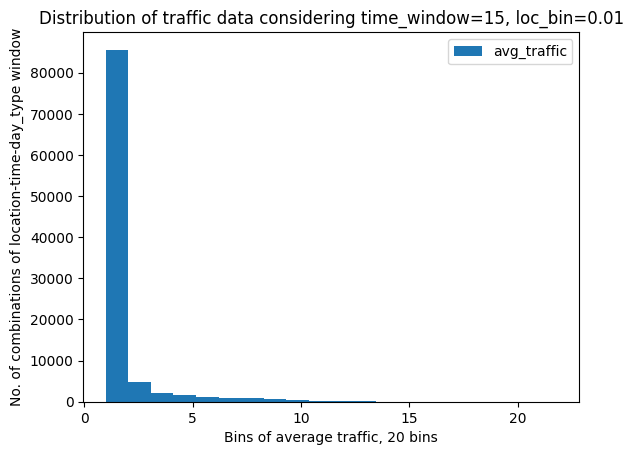

In [18]:
# Visualize how the traffic data is distributed
derive_traffic(tr_filt).plot.hist(y='avg_traffic', bins=20)
plt.xlabel("Bins of average traffic, 20 bins")
plt.ylabel("No. of combinations of location-time-day_type window")
plt.title("Distribution of traffic data considering time_window=15, loc_bin=0.01")
# Check distance if we increase lat-long by 0.01
print(HaversineDistance(40,-70,40.01,-70.01))#*np.sqrt(2)/1.6)

(1449186, 28)


Text(0.5, 1.0, 'Scatter plot of log(duration) vs traffic_pickup + traffic_dropoff')

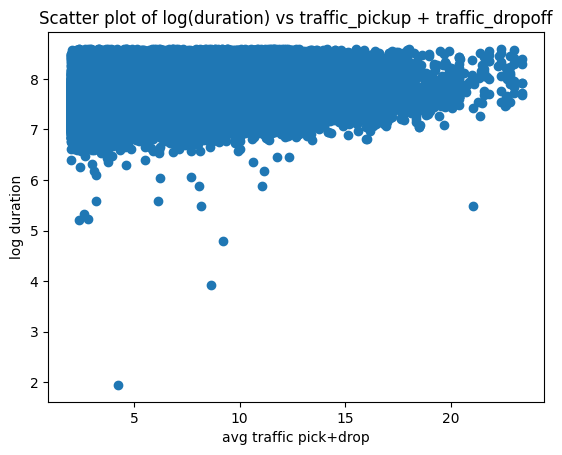

In [19]:
# Trying to figure out with different time window bins and location bins, how the traffic data would relate with duration
traffic_df = derive_traffic(tr_filt, time_window=15, loc_bin=0.01)

train_feat = create_features(tr_filt, traffic_df, time_window=15, loc_bin=0.01)
print(train_feat.shape)

(
    plt.scatter(
        (train_feat.loc[(train_feat.distance>12),'avg_traffic_pick'])+(train_feat.loc[(train_feat.distance>12),'avg_traffic_drop']), 
        np.log(train_feat.loc[(train_feat.distance>12),'trip_duration'])
    )
)
plt.xlabel('avg traffic pick+drop')
plt.ylabel('log duration')
plt.title('Scatter plot of log(duration) vs traffic_pickup + traffic_dropoff')

After few experiments of different time window (15 mins, 30 mins, 60 mins) and different location bin widths (0.01, 0.02, 0.03), decided to stick with 15 mins window and 0.01 location bin width as the scatter plot seemed more linear for this combination than others.

----------
#### Model experiments

In [20]:
# Import required SKLearn libraries
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error

# Name of features to be considered for modeling
feat_cols = [
    # 'pick_day_b', 'pick_hour_b',
    'pick_day', 'pick_hour',
    'avg_traffic_pick', 'vendor_id', 'pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pax_b', 
    # 'distance', 
    'pick_day_hour', 'pick_month', 'holiday_around', 'avg_traffic_drop',
    'log_distance'
]
# Features to be tagged as categorical
categorical_columns_subset = [
    # 'pick_day_b', 'pick_hour_b', 
    'pick_day', 'pick_hour', 
    'pax_b', 'pick_day_hour', 'pick_month',
    'vendor_id', 'store_and_fwd_flag', 'holiday_around'
]
# Features to be tagged as numeric
numerical_columns_subset = list(set(feat_cols).difference(set(categorical_columns_subset)))

# X and y from outlier removed training data
y=tr_filt.loc[:,'trip_duration'].copy()
X=tr_filt.drop(columns=['trip_duration']).copy()

# Split the data to create train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=44
)

# Create features
traffic_df_train = derive_traffic(X_train, time_window=15, loc_bin=0.01)
X_train_f = create_features(X_train, traffic_df_train, time_window=15, loc_bin=0.01).loc[:,feat_cols]
# Change data type of categorical data to 'category'
X_train_f[categorical_columns_subset] = X_train_f[categorical_columns_subset].astype("category")
n_categorical_features = X_train_f.select_dtypes(include="category").shape[1]
n_numerical_features = X_train_f.select_dtypes(include="number").shape[1]
print(f"Number of training samples: {X_train_f.shape[0]}")
print(f"Number of features: {X_train_f.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

X_valid_f = create_features(X_valid, traffic_df_train, time_window=15, loc_bin=0.01).loc[:,feat_cols]
X_valid_f[categorical_columns_subset] = X_train_f[categorical_columns_subset].astype("category")


Number of training samples: 1304267
Number of features: 15
Number of categorical features: 8
Number of numerical features: 7


In [21]:
# Scale, then one-hot encoding of categorical features
one_hot_encoder = make_column_transformer(
    (
        StandardScaler(),
        make_column_selector(dtype_include="number"),
    ),
    (
        OneHotEncoder(sparse=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)
# Random forest with default params - changed max_features and min_samples_leaf as it was taking huge time otherwise
rf_one_hot = make_pipeline(
    one_hot_encoder, 
    RandomForestRegressor(random_state=44, min_samples_leaf=10, max_features='sqrt', n_jobs=2)
)

# Scale, then ordinal encoding of categorical features
ordinal_encoder = make_column_transformer(
    (
        StandardScaler(),
        make_column_selector(dtype_include="number"),
    ),
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)
# HistGradient boosting with default params and specific categorical feature tagging
categorical_mask = [False] * n_numerical_features + [True] * n_categorical_features
hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        random_state=44, categorical_features=categorical_mask, scoring="neg_mean_squared_error"
    ),
)

In [22]:
# Trying Gamma regression
gamma_one_hot = make_pipeline(
    one_hot_encoder, 
    GammaRegressor(alpha=0.01)
)
gamma_one_hot.fit(X_train_f, y_train)
print(f"Gamma RMSLE train: {mean_squared_log_error(y_train, gamma_one_hot.predict(X_train_f), squared=False)}")
print(f"Gamma RMSLE validation: {mean_squared_log_error(y_valid, gamma_one_hot.predict(X_valid_f), squared=False)}")


Gamma RMSLE train: 0.43985251373460915
Gamma RMSLE validation: 0.49012298154120726


In [23]:
# RF & HistGB cross-validated results
scoring = "neg_mean_squared_error"
n_cv_folds = 3

rf_one_hot_result = cross_validate(rf_one_hot, X_train_f, np.log(y_train), cv=n_cv_folds, scoring=scoring)
hist_native_result = cross_validate(hist_native, X_train_f, np.log(y_train), cv=n_cv_folds, scoring=scoring)

print(f"RF one-hot encode mean CV RMSLE {np.mean(np.sqrt(np.abs(rf_one_hot_result['test_score'])))}")
print(f"HistGB native categorical mean CV RMSLE {np.mean(np.sqrt(np.abs(hist_native_result['test_score'])))}")

RF one-hot encode mean CV RMSLE 0.3758089916055177
HistGB native categorical mean CV RMSLE 0.3680761917515914


> Hyper-parameter tuning of HistGB in parts. Continuing with HistGB as it produced better CV result than RF and Gamma regressor

In [24]:
# Hyper parameter tuning of HistGB - part A
param_grid = dict(
    histgradientboostingregressor__learning_rate=[0.05, 0.1, 0.2],
    histgradientboostingregressor__max_bins=[50,100,255]
)
grid_search = GridSearchCV(hist_native, param_grid=param_grid, cv=5, scoring=["neg_mean_squared_error"], refit="neg_mean_squared_error")
grid_search.fit(X_train_f, np.log(y_train))
cv_res=pd.DataFrame(grid_search.cv_results_)
display(cv_res)

print(f"RMSLE tuning part A on training data: {mean_squared_log_error(y_train, np.exp(grid_search.predict(X_train_f)), squared=False)}")
print(f"RMSLE tuning part A on validation data: {mean_squared_log_error(y_valid, np.exp(grid_search.predict(X_valid_f)), squared=False)}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_bins,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,59.980145,10.425350,2.369212,0.267929,0.05,50,{'histgradientboostingregressor__learning_rate...,-0.148970,-0.150919,-0.149137,-0.148694,-0.148944,-0.149333,0.000806,9
1,39.656143,7.783108,1.631003,0.195814,0.05,100,{'histgradientboostingregressor__learning_rate...,-0.146926,-0.149263,-0.147379,-0.146707,-0.147514,-0.147557,0.000902,8
2,36.092913,0.203853,1.716224,0.086740,0.05,255,{'histgradientboostingregressor__learning_rate...,-0.144388,-0.147083,-0.145632,-0.144745,-0.144713,-0.145312,0.000977,7
3,36.474757,6.808583,1.819538,0.327827,0.1,50,{'histgradientboostingregressor__learning_rate...,-0.138956,-0.141694,-0.139278,-0.138914,-0.139336,-0.139636,0.001043,6
4,444.167218,815.193363,1.710846,0.131914,0.1,100,{'histgradientboostingregressor__learning_rate...,-0.136958,-0.139443,-0.137569,-0.137364,-0.137478,-0.137762,0.000866,5
5,34.904163,0.837364,1.840550,0.112079,0.1,255,{'histgradientboostingregressor__learning_rate...,-0.134458,-0.137932,-0.136393,-0.135133,-0.134571,-0.135697,0.001311,4
6,33.367018,3.016493,1.750729,0.063406,0.2,50,{'histgradientboostingregressor__learning_rate...,-0.132590,-0.135888,-0.133813,-0.132431,-0.133185,-0.133582,0.001252,3
7,313.246103,559.853683,1.661053,0.196632,0.2,100,{'histgradientboostingregressor__learning_rate...,-0.130866,-0.133400,-0.132078,-0.131537,-0.131833,-0.131943,0.000834,2
8,37.900078,6.495163,2.017007,0.425945,0.2,255,{'histgradientboostingregressor__learning_rate...,-0.128191,-0.131785,-0.130845,-0.129252,-0.130033,-0.130021,0.001244,1


RMSLE tuning part A on training data: 0.35171222981251554
RMSLE tuning part A on validation data: 0.4609587729581826


In [25]:
# Hyper parameter tuning of HistGB - part B
param_grid = dict(
    histgradientboostingregressor__learning_rate=[0.25, 0.3, 0.4],
    histgradientboostingregressor__min_samples_leaf=[20,30],
    histgradientboostingregressor__max_iter=[100, 150]
)
grid_search = GridSearchCV(hist_native, param_grid=param_grid, cv=5, scoring=["neg_mean_squared_error"], refit="neg_mean_squared_error")
grid_search.fit(X_train_f, np.log(y_train))
cv_res=pd.DataFrame(grid_search.cv_results_)
display(cv_res)

print(f"RMSLE tuning part B on training data: {mean_squared_log_error(y_train, np.exp(grid_search.predict(X_train_f)), squared=False)}")
print(f"RMSLE tuning part B on validation data: {mean_squared_log_error(y_valid, np.exp(grid_search.predict(X_valid_f)), squared=False)}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_iter,param_histgradientboostingregressor__min_samples_leaf,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,32.472184,1.469049,1.960947,0.565931,0.25,100,20,{'histgradientboostingregressor__learning_rate...,-0.127205,-0.130593,-0.128365,-0.127278,-0.127552,-0.128199,0.001266,12
1,41.422003,4.673797,1.662710,0.224180,0.25,100,30,{'histgradientboostingregressor__learning_rate...,-0.126961,-0.130455,-0.128669,-0.127365,-0.127394,-0.128169,0.001279,11
2,87.967894,8.590114,2.638146,0.728084,0.25,150,20,{'histgradientboostingregressor__learning_rate...,-0.124693,-0.127619,-0.125411,-0.125100,-0.124826,-0.125530,0.001073,6
3,84.010596,9.477201,2.537280,0.471789,0.25,150,30,{'histgradientboostingregressor__learning_rate...,-0.123851,-0.126965,-0.126014,-0.124796,-0.124895,-0.125304,0.001077,5
4,47.759634,3.439357,2.283219,0.261018,0.3,100,20,{'histgradientboostingregressor__learning_rate...,-0.126700,-0.129079,-0.128003,-0.127745,-0.127366,-0.127779,0.000784,10
5,44.939796,6.739222,2.118288,0.443737,0.3,100,30,{'histgradientboostingregressor__learning_rate...,-0.126107,-0.129416,-0.127775,-0.126523,-0.127023,-0.127369,0.001165,9
6,81.767868,7.938666,2.644604,0.810721,0.3,150,20,{'histgradientboostingregressor__learning_rate...,-0.123784,-0.126758,-0.125322,-0.124641,-0.124168,-0.124935,0.001046,3
7,79.007706,13.511844,2.585839,0.528729,0.3,150,30,{'histgradientboostingregressor__learning_rate...,-0.123593,-0.126050,-0.127837,-0.124376,-0.124362,-0.125244,0.001525,4
8,43.560729,7.207047,1.979033,0.392034,0.4,100,20,{'histgradientboostingregressor__learning_rate...,-0.126260,-0.128425,-0.127162,-0.126110,-0.126707,-0.126933,0.000832,7
9,39.251650,10.239871,1.749348,0.195518,0.4,100,30,{'histgradientboostingregressor__learning_rate...,-0.126302,-0.128934,-0.127982,-0.126094,-0.125530,-0.126969,0.001278,8


RMSLE tuning part B on training data: 0.3374832513987304
RMSLE tuning part B on validation data: 0.46589699871390955


In [26]:
# Hyper parameter tuning of HistGB - part C
param_grid = dict(
    histgradientboostingregressor__learning_rate=[0.3],
    histgradientboostingregressor__min_samples_leaf=[20],
    histgradientboostingregressor__max_iter=[175, 200, 250, 300]
)
grid_search = GridSearchCV(hist_native, param_grid=param_grid, cv=5, scoring=["neg_mean_squared_error"], refit="neg_mean_squared_error")
grid_search.fit(X_train_f, np.log(y_train))
cv_res=pd.DataFrame(grid_search.cv_results_)
display(cv_res)

print(f"RMSLE tuning part C on training data: {mean_squared_log_error(y_train, np.exp(grid_search.predict(X_train_f)), squared=False)}")
print(f"RMSLE tuning part C on validation data: {mean_squared_log_error(y_valid, np.exp(grid_search.predict(X_valid_f)), squared=False)}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_iter,param_histgradientboostingregressor__min_samples_leaf,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,112.395474,13.187039,2.738788,0.223355,0.3,175,20,{'histgradientboostingregressor__learning_rate...,-0.123074,-0.125889,-0.124100,-0.123922,-0.122998,-0.123996,0.001044,4
1,119.458245,15.659649,2.908249,0.319593,0.3,200,20,{'histgradientboostingregressor__learning_rate...,-0.122257,-0.124721,-0.123527,-0.123302,-0.122064,-0.123174,0.000960,3
2,184.053053,14.243478,4.408850,0.984859,0.3,250,20,{'histgradientboostingregressor__learning_rate...,-0.121229,-0.123723,-0.122380,-0.122218,-0.121337,-0.122177,0.000899,2
3,258.337034,39.396483,4.497559,1.074210,0.3,300,20,{'histgradientboostingregressor__learning_rate...,-0.120185,-0.122905,-0.121650,-0.121238,-0.121337,-0.121463,0.000874,1


RMSLE tuning part C on training data: 0.3284087628601541
RMSLE tuning part C on validation data: 0.464316322023443


In [22]:
# Train final model on full data
hist_native_f = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(
        learning_rate=0.3, max_iter=300,
        random_state=44, categorical_features=categorical_mask, scoring="neg_mean_squared_error"
    ),
)
# Consider full training data (X & y as defined earlier before train-test split)
# Recreate traffic master data - as the validation X data kept out earlier is also being used now
traffic_df_train_full = derive_traffic(X, time_window=15, loc_bin=0.01)
# Recreate the features using updated traffic master data and full training data (X)
X_train_full = create_features(X, traffic_df_train_full, time_window=15, loc_bin=0.01).loc[:,feat_cols]
# Change data type of categorical data to 'category'
X_train_full[categorical_columns_subset] = X_train_full[categorical_columns_subset].astype("category")

# Train model using full training data
hist_native_f.fit(X_train_full, np.log(y))

print(f"RMSLE of tuned model on full training data: {mean_squared_log_error(y, np.exp(hist_native_f.predict(X_train_full)), squared=False)}")

# Test data from Kaggle
test = pd.read_csv("test.zip", parse_dates=["pickup_datetime"], infer_datetime_format=True)
# Create features on test data
X_test_f = create_features(test, traffic_df_train, time_window=15, loc_bin=0.01).loc[:,feat_cols]
# Change datatype of categorical variables
X_test_f[categorical_columns_subset] = X_test_f[categorical_columns_subset].astype("category")

# Generate submission file on Kaggle hosted test data
kaggle_sub=pd.DataFrame({"id": test.loc[:,"id"], "trip_duration": np.exp(hist_native_f.predict(X_test_f))})
kaggle_sub.to_csv("kaggle_sub.csv", index=False)

RMSLE of tuned model on full training data: 0.32857143023984625


> Feature importance based on final model fit

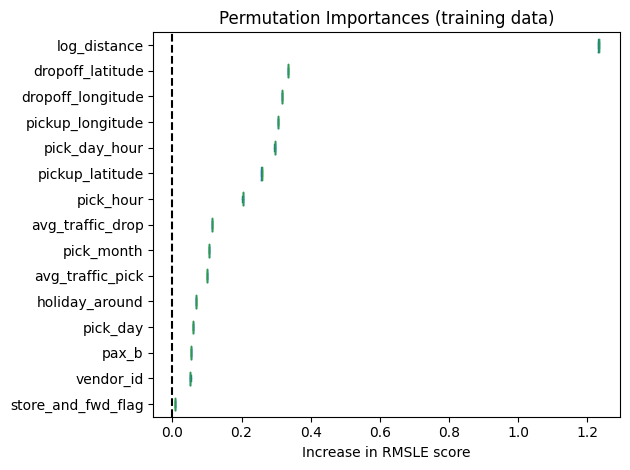

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(hist_native_f, X_train_full, np.log(y), n_repeats=10, random_state=44, n_jobs=2)
# Visualize
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    np.sqrt(np.abs(result.importances[sorted_importances_idx].T)),
    # result.importances[sorted_importances_idx].T,
    columns=X_train_full.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (training data)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Increase in RMSLE score")
ax.figure.tight_layout()


------------
Some further improvements could be:  
1. There were many data points having distance <0.01 KM; instead of discarding them, since we applied log transformation on distance, may be it may help to add an indicator variable to flag if distance is very small. (log(0) tends to negative infinity!)
2. We could have used all the passenger counts instead of bucketing them as 1, 2 to 4, >4 etc. as we can build HistGB model without increasing the number of variables.
3. Creating cluster of co-ordinates based on traffic, duration etc. may help improving the predictive power. Basically using co-ordinates as numeric variable does not make much sense, rather using them to create categorical features could have made more sense.
4. Some other modeling algo e.g. neural network could be tried.
